# ***Scandinavian News Articles***

This notebook is a part of the final project in *Computational Tools for data science 02807*

### ***Imports***

In [215]:
import pandas as pd 
from IPython.display import display, HTML

### ***Import Dataset***

The datasets have been scraped using ..

In [216]:
news_articles = pd.read_csv('data/articles.csv')

# information about the dataset
news_articles.shape[0]
news_articles.info()
news_articles.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             1192 non-null   object
 1   headline         1192 non-null   object
 2   content          1192 non-null   object
 3   url              1192 non-null   object
 4   source           1192 non-null   object
 5   country          1192 non-null   object
 6   worldview_score  1192 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 65.3+ KB


,date,headline,content,url,source,country,worldview_score
0,2024-04-10,Skakande orden i rätten: ”Rann blod i mina ögon”,Under 30 minuter misshandlade de tre män och h...,https://www.aftonbladet.se/nyheter/a/OoLd3k/na...,Aftonbladet,sweden,3
1,2021-03-30,Trumps vändning: Blir inga matkuponger,Det blir inga utbetalningar av matkuponger för...,https://www.aftonbladet.se/nyheter/a/GyvQb9/tr...,Aftonbladet,sweden,3
2,2021-01-27,Skakande orden i rätten: ”Rann blod i mina ögon”,/ Under 30 minuter misshandlade de tre män och...,https://www.aftonbladet.se/nyheter/a/OoLd3k/na...,Aftonbladet,sweden,3
3,2025-09-23,"Trump drømmer om fredspris, men siden torsdag ...","Trump har både harceleret mod ""Forever Wars"" o...",https://www.dr.dk/nyheder/udland/trump-droemme...,DR,denmark,3
4,2024-07-05,Kina forbyder influencere at dele sundhedstips...,Intentionen med loven er at forhindre sprednin...,https://www.dr.dk/nyheder/udland/kina-forbyder...,DR,denmark,3


### ***Preprocessing Steps***

#### 1. Clean content 

In [217]:
import re
import pandas as pd

# 1) Define "boilerplate" markers you want to cut away and everything after
SUBSCRIPTION_MARKERS = [
    "Allerede abonnent? Log ind",
    "Allerede abonnent? Log ind her",
    "Log ind for at læse",
    "Log ind for at læse hele artiklen",
    "Log ind for at læse videre",
    "Logg inn for å lese",
    "Bli abonnent",
    "Tegn abonnement",
    "Få adgang til hele artiklen",
    "Få adgang til alt indhold",

    # Swedish / Norwegian / Danish "read more" prompts
    "Läs mer",       # SE
    "Læs mere",      # DK
    "Les mer",       # NO

    # DN print-view header
    "En utskrift från Dagens Nyheter",
]

def clean_content(text: str) -> str:
    if pd.isna(text):
        return ""
    t = str(text)

    # --- basic formatting fixes ---
    # remove leading "/ " like "/ Under 30 minuter ..."
    t = re.sub(r'^\s*/\s*', '', t)

    # remove bullet characters that often appear in scraped content
    t = t.replace("•", " ")

    # --- cut off subscription / boilerplate tail ---
    lower = t.lower()
    cut_pos = len(t)
    for marker in SUBSCRIPTION_MARKERS:
        idx = lower.find(marker.lower())
        if idx != -1 and idx < cut_pos:
            cut_pos = idx

    t = t[:cut_pos]

    # --- normalize whitespace ---
    t = re.sub(r'\s+', ' ', t).strip()

    return t

# Apply to your dataframe
news_articles['content_clean'] = news_articles['content'].apply(clean_content)

news_articles.head(5)


,date,headline,content,url,source,country,worldview_score,content_clean
0,2024-04-10,Skakande orden i rätten: ”Rann blod i mina ögon”,Under 30 minuter misshandlade de tre män och h...,https://www.aftonbladet.se/nyheter/a/OoLd3k/na...,Aftonbladet,sweden,3,Under 30 minuter misshandlade de tre män och h...
1,2021-03-30,Trumps vändning: Blir inga matkuponger,Det blir inga utbetalningar av matkuponger för...,https://www.aftonbladet.se/nyheter/a/GyvQb9/tr...,Aftonbladet,sweden,3,Det blir inga utbetalningar av matkuponger för...
2,2021-01-27,Skakande orden i rätten: ”Rann blod i mina ögon”,/ Under 30 minuter misshandlade de tre män och...,https://www.aftonbladet.se/nyheter/a/OoLd3k/na...,Aftonbladet,sweden,3,Under 30 minuter misshandlade de tre män och h...
3,2025-09-23,"Trump drømmer om fredspris, men siden torsdag ...","Trump har både harceleret mod ""Forever Wars"" o...",https://www.dr.dk/nyheder/udland/trump-droemme...,DR,denmark,3,"Trump har både harceleret mod ""Forever Wars"" o..."
4,2024-07-05,Kina forbyder influencere at dele sundhedstips...,Intentionen med loven er at forhindre sprednin...,https://www.dr.dk/nyheder/udland/kina-forbyder...,DR,denmark,3,Intentionen med loven er at forhindre sprednin...


#### 1. Remove irrelevant links

In some norwegian articles posted by "vg.no" there are links to another website called "e24.no". These are not relevant for the project, and are therefore dropped from the data frame

In [218]:
# drop all norwegian articles from "vg" that contains "e24" in the url
e24_links = news_articles[(news_articles['country'] == 'norway') & (news_articles['source'] == 'vg') & (news_articles['url'].str.contains('https://e24.no'))]
news_articles = news_articles.drop(e24_links.index)
news_articles.reset_index(drop=True, inplace=True)

# print number of articles after preprocessing
print("Number of articles after preprocessing:", news_articles.shape[0])

Number of articles after preprocessing: 1184


#### 2. Remove invalid source

During scraping the source "news" has been included, which is not a valid source. Rows with this source has also been dropped. 

In [219]:
# count rows with source "news"
invalid_source = news_articles[news_articles['source'] == 'news']
print("Number of articles with source 'news':", invalid_source.shape[0])

# drop rows with source "news"
news_articles = news_articles[news_articles['source'] != 'news']
news_articles.reset_index(drop=True, inplace=True)
print("Number of articles after dropping 'news' source:", news_articles.shape[0])

Number of articles with source 'news': 9
Number of articles after dropping 'news' source: 1175


#### 3. Standardize source names

Some sources have uppercase letters and some not, so we standardize by only using lowercase.

In [220]:
news_articles['source'] = news_articles['source'].str.lower()

#### 4. Remove articles outside the intended time period 2020-2025

In [221]:
news_articles['date'] = pd.to_datetime(news_articles['date'], errors='coerce')
news_articles = news_articles[(news_articles['date'] >= '2020-01-01') & (news_articles['date'] <= '2025-12-31')]
news_articles.reset_index(drop=True, inplace=True)
print("Number of articles after removing those outside 2020-2025:", news_articles.shape[0])

Number of articles after removing those outside 2020-2025: 1172


#### 5. Remove duplicates

In [222]:
# 1. Drop strict duplicates (same URL + same content + same headline)
news_articles = news_articles.drop_duplicates(
    subset=['url', 'source', 'content_clean', 'headline']
).reset_index(drop=True)

print("After strict duplicates:", news_articles.shape[0])

# 2. Drop soft duplicates (same content/headline but different URL)
news_articles = news_articles.drop_duplicates(
    subset=['content_clean', 'headline']
).reset_index(drop=True)

print("After soft duplicates:", news_articles.shape[0])


After strict duplicates: 1090
After soft duplicates: 1042


#### 6. Drop articles with worldview score 6, i.e., not classified

In [223]:
news_articles = news_articles[news_articles['worldview_score'] != 6]
news_articles.reset_index(drop=True, inplace=True)
print("Number of articles after dropping unclassified worldview score:", news_articles.shape[0])

Number of articles after dropping unclassified worldview score: 592


### ***Dataset Exploration***

#### Source information

The table below presents information about the sources we have retrieved. 

In [224]:
unique_sources = news_articles[['country', 'source']].drop_duplicates().sort_values(by='country')

sources_per_country = unique_sources['country'].value_counts()
display(HTML("<h4 style='font-weight:700'>Number of Sources per Country:</h4>"))
display(HTML("<pre style='font-family:monospace'>{}</pre>".format(
    sources_per_country.rename(index=lambda s: s.capitalize()).to_string(header=False)
)))

src_counts = (news_articles
              .groupby(['country', 'source'])
              .size()
              .reset_index(name='n_articles'))

# compute average worldview_score per country and source
temp_view = news_articles.copy()
temp_view['worldview_num'] = pd.to_numeric(temp_view['worldview_score'], errors='coerce')
avg_world = temp_view.groupby(['country', 'source'])['worldview_num'].mean().reset_index(name='avg_worldview').round(2)
display_df = src_counts.merge(avg_world, on=['country', 'source'], how='left')

# add column showing the time range of articles per country and source
time_ranges = (news_articles
                .groupby(['country', 'source'])
                .agg(first_article=('date', 'min'), last_article=('date', 'max'))
                .reset_index())

time_ranges['time_range'] = (
    time_ranges['first_article'].dt.strftime('%Y-%m-%d') +
    ' to ' +
    time_ranges['last_article'].dt.strftime('%Y-%m-%d')
)

display_df = display_df.merge(time_ranges[['country', 'source', 'time_range']], on=['country', 'source'])  
display_df = display_df[['source', 'n_articles', 'avg_worldview', 'country', 'time_range']]
display_df = display_df.sort_values(by='country').copy()
display(HTML(display_df.to_html(index=False, border=0)))


source,n_articles,avg_worldview,country,time_range
berlingske,96,2.32,denmark,2020-11-11 to 2025-10-29
dr,172,2.53,denmark,2020-11-15 to 2025-10-23
information,38,3.00,denmark,2020-12-04 to 2025-10-24
jyllands-posten,98,2.39,denmark,2020-11-19 to 2025-10-10
politiken,2,3.00,denmark,2021-12-02 to 2024-02-18
aftenposten,2,3.00,norway,2021-04-30 to 2024-08-24
dagbladet,2,4.00,norway,2020-11-08 to 2024-01-23
nrk,35,2.57,norway,2020-11-30 to 2025-06-28
vg,41,2.46,norway,2021-01-09 to 2025-11-05
aftonbladet,25,2.68,sweden,2021-03-30 to 2025-09-03


#### Article Distribution

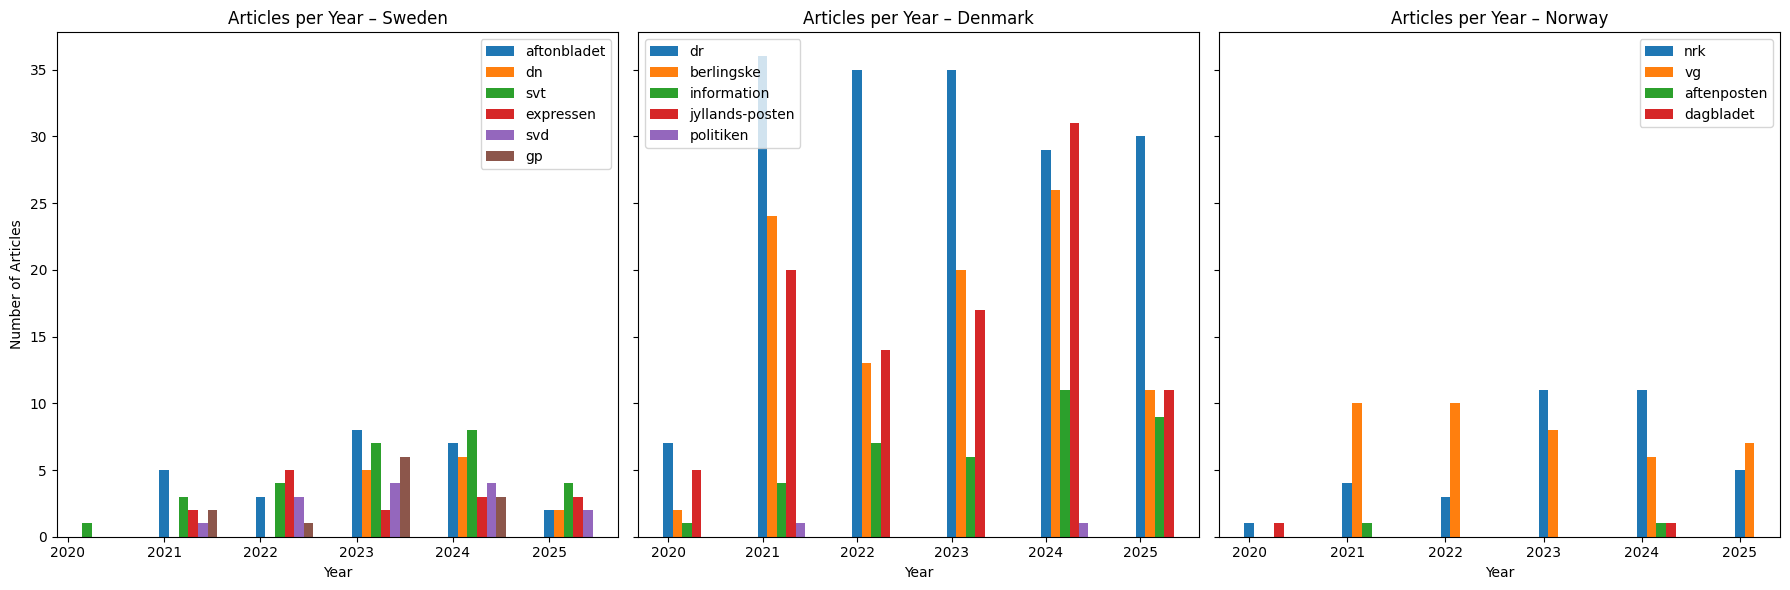

In [225]:
import matplotlib.pyplot as plt

countries = news_articles['country'].unique()
num_countries = len(countries)

fig, axes = plt.subplots(1, num_countries, figsize=(18, 6), sharey=True)

if num_countries == 1:
    axes = [axes]

for ax, country in zip(axes, countries):
    country_data = news_articles[news_articles['country'] == country].copy()

    for i, source in enumerate(country_data['source'].unique()):
        source_data = country_data[country_data['source'] == source].copy()
        source_data['year'] = source_data['date'].dt.year
        year_counts = source_data['year'].value_counts().sort_index()

        ax.bar(
            year_counts.index + (0.1 * i),
            year_counts.values,
            width=0.1,
            label=source
        )

    ax.set_title(f'Articles per Year – {country.capitalize()}')
    ax.set_xlabel('Year')
    ax.set_xticks(range(2020, 2026))
    ax.legend()

axes[0].set_ylabel('Number of Articles')

plt.tight_layout()
plt.show()


#### Average Worldview in each Country from 2020-2025

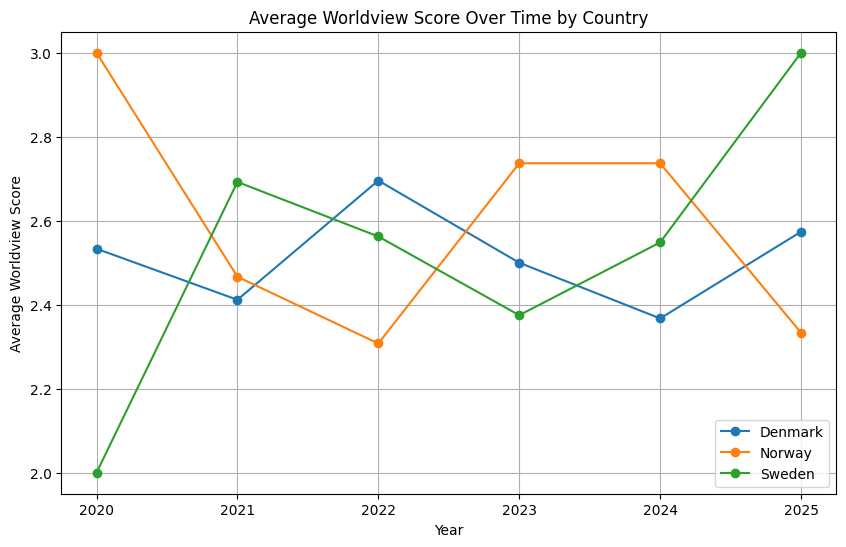

In [226]:
import matplotlib.pyplot as plt
worldview_over_time = (news_articles
                       .copy())
worldview_over_time['worldview_num'] = pd.to_numeric(worldview_over_time['worldview_score'], errors='coerce')
worldview_over_time['year'] = worldview_over_time['date'].dt.year
avg_worldview_time = (worldview_over_time
                      .groupby(['country', 'year'])['worldview_num']
                      .mean()
                      .reset_index())

plt.figure(figsize=(10, 6))
for country in avg_worldview_time['country'].unique():
    country_data = avg_worldview_time[avg_worldview_time['country'] == country]
    plt.plot(country_data['year'], country_data['worldview_num'], marker='o', label=country.capitalize())

    
plt.title('Average Worldview Score Over Time by Country')
plt.xlabel('Year')
plt.ylabel('Average Worldview Score')
plt.xticks(avg_worldview_time['year'].unique())
plt.legend()
plt.grid()
plt.show()

### ***TF-IDF***

In [228]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

base_stopwords = set(stopwords.words('english') +
                       stopwords.words('swedish') +
                       stopwords.words('danish') +
                       stopwords.words('norwegian'))

# Domain-specific extra stopwords: outlets, generic news words, light verbs/adverbs
extra_stopwords = {
    "vg", "nrk", "aftonbladet", "dr", "artikler", "artikkel", "artikel",
    "sier", "mener", "siste", "litt", "mye", "mer", "år", "dag", "dager",
    "blant", "andre", "må", "fikk", "veldig", "annet", "går", "nå",
    "uten", "over", "etter", "inn", "to", "via", "se", "gå", "kom", "kommet",
    "ifølge", "har", "ha", "være", "viktig", "nyhet", "nyheter", "les", "lese",
    # add more as you notice junk terms
}

custom_stopwords = list(base_stopwords.union(extra_stopwords))

vectorizer = TfidfVectorizer(
    stop_words=custom_stopwords,   # must be list, not set
    max_features=5000,
    ngram_range=(1, 2)
)

news_articles['text'] = news_articles['headline'].fillna('') + " " + news_articles['content'].fillna('')
tfidf_matrix = vectorizer.fit_transform(news_articles['text'])

feature_names = vectorizer.get_feature_names_out()


print("TF-IDF shape:", tfidf_matrix.shape)


TF-IDF shape: (592, 5000)


In [229]:
def top_tfidf_terms(mask, n=30):
    sub = tfidf_matrix[mask]
    mean_scores = sub.mean(axis=0).A1
    top_idx = mean_scores.argsort()[::-1][:n]
    return [(feature_names[i], mean_scores[i]) for i in top_idx]

# Example: top terms for Sweden
sweden_mask = news_articles['country'] == 'sweden'
top_tfidf_terms(sweden_mask)


[('ska', 0.05837669925046862),
 ('säger', 0.05534910838291025),
 ('new', 0.031893185264347874),
 ('flera', 0.03128792990203079),
 ('enligt', 0.029289918258043543),
 ('mamdani', 0.02825593577330057),
 ('nya', 0.025829960036308375),
 ('mån', 0.02433798148273969),
 ('också', 0.023627839471097443),
 ('kr', 0.022612898416129207),
 ('new york', 0.020537816800017213),
 ('vill', 0.02051846388697013),
 ('york', 0.020275880386673304),
 ('zohran', 0.019981382286555056),
 ('polisen', 0.019760366031959537),
 ('första', 0.019610092589532002),
 ('svt', 0.019306298113763307),
 ('kr mån', 0.01792905483349344),
 ('läs', 0.017870976695636302),
 ('dn', 0.01775252591389462),
 ('zohran mamdani', 0.01749028049266505),
 ('vet', 0.017390436550530623),
 ('kriget', 0.01689497957057383),
 ('trump', 0.01602063277621285),
 ('israel', 0.01561352966600703),
 ('eu', 0.01561006559153067),
 ('även', 0.015495357103304746),
 ('måste', 0.015414795331468499),
 ('2025', 0.015191612753765628),
 ('andra', 0.014972472278191049)

### Test some LSH 

In [230]:
import re
import pandas as pd

# If not already there: combine headline + content
news_articles['combined'] = news_articles['headline'].fillna('') + ' ' + news_articles['content'].fillna('')

def get_shingles(text, k=5):
    """
    Create word shingles (k-grams) from a text.
    Example: k=5 means sequences of 5 consecutive words.
    """
    # basic tokenization: keep alphanumeric words
    tokens = re.findall(r'\w+', str(text).lower())
    if len(tokens) < k:
        return set([' '.join(tokens)]) if tokens else set()
    return {
        ' '.join(tokens[i:i + k])
        for i in range(len(tokens) - k + 1)
    }

# Quick test on one article:
example_shingles = get_shingles(news_articles['combined'].iloc[3], k=5)
len(example_shingles), list(example_shingles)[:5]


(325,
 ['officielle forklaring i kina vil',
  'platforme som weibo og douyin',
  'eventuelle forbehold men udover bekæmpelse',
  'version af tiktok bliver fremover',
  'viden om økonomi eller reklamerer'])

In [231]:
from datasketch import MinHash

def create_minhash(shingles, num_perm=128):
    """
    Build a MinHash signature from a set of shingles.
    num_perm controls the signature size (and accuracy).
    """
    m = MinHash(num_perm=num_perm)
    for sh in shingles:
        m.update(sh.encode('utf-8'))
    return m

num_perm = 128
k = 5  # shingle size

minhashes = {}

for idx, text in news_articles['text'].items():
    shingles = get_shingles(text, k=k)
    m = create_minhash(shingles, num_perm=num_perm)
    minhashes[idx] = m

len(minhashes)


592

In [232]:
from datasketch import MinHashLSH

# threshold ≈ Jaccard similarity threshold
lsh_threshold = 0.5  # try 0.5–0.8 depending on how strict you want it

lsh = MinHashLSH(threshold=lsh_threshold, num_perm=num_perm)

for idx, m in minhashes.items():
    # keys must be hashable; we'll use string of index
    lsh.insert(str(idx), m)


In [233]:
import numpy as np

similar_pairs = set()  # to avoid duplicates like (3, 5) and (5, 3)

for i, m in minhashes.items():
    neighbors = lsh.query(m)
    for j in neighbors:
        j = int(j)
        if j == i:
            continue
        pair = tuple(sorted((i, j)))
        similar_pairs.add(pair)

len(similar_pairs)



7

In [239]:
results = []

for i, j in similar_pairs:
    sim_est = minhashes[i].jaccard(minhashes[j])  # approx Jaccard
    results.append((sim_est, i, j))

# Sort by similarity (highest first)
results.sort(reverse=True, key=lambda x: x[0])

# Show top N similar pairs
N = 20
for sim, i, j in results[:N]:
    print(f"\nPair: {i} – {j} | est. Jaccard: {sim:.3f}")
    print("A:", news_articles.loc[i, 'headline'])
    print("B:", news_articles.loc[j, 'headline'])
    print("Sources:", news_articles.loc[i, 'source'], "|", news_articles.loc[j, 'source'])
    print("Countries:", news_articles.loc[i, 'country'], "|", news_articles.loc[j, 'country'])


Pair: 274 – 380 | est. Jaccard: 1.000
A: AaB vil sikre likviditet til strategi med kapitaludvidelse
B: AaB vil sikre likviditet til strategi med kapitaludvidelse
Sources: jyllands-posten | berlingske
Countries: denmark | denmark

Pair: 67 – 74 | est. Jaccard: 0.805
A: Ansøgninger fra Bangladesh og Nepal til uddannelser falder efter stramninger
B: Ansøgninger fra Bangladesh og Nepal til uddannelser falder efter stramninger
Sources: dr | jyllands-posten
Countries: denmark | denmark

Pair: 268 – 273 | est. Jaccard: 0.656
A: Politi anholder mand i Risskov mistænkt i sag om angrebsplan i Tyskland
B: Politi anholder mand i Risskov mistænkt i spionagesag i Tyskland
Sources: berlingske | jyllands-posten
Countries: denmark | denmark

Pair: 159 – 188 | est. Jaccard: 0.461
A: Stor insats på Stegra – flera enheter på plats0:25
B: Stor insats på Stegra – flera enheter på plats0:25
Sources: aftonbladet | aftonbladet
Countries: sweden | sweden

Pair: 150 – 189 | est. Jaccard: 0.430
A: Akut säkerhets

In [238]:
# print details of pair 145 and 468
i, j = 146, 468
print(f"\nPair: {i} – {j} | est. Jaccard: {minhashes[i].jaccard(minhashes[j]):.3f}")
print("A:", news_articles.loc[i, 'headline'])
print("B:", news_articles.loc[j, 'headline'])
print("Sources:", news_articles.loc[i, 'source'], "|", news_articles.loc[j, 'source'])
print("Countries:", news_articles.loc[i, 'country'], "|", news_articles.loc[j, 'country'])
print("Content" 
      ,"\nA:", news_articles.loc[i, 'content_clean'][:200], "...\nB:", news_articles.loc[j, 'content_clean'][:200], "...")
print("url", news_articles.loc[i, 'url'], "|", news_articles.loc[j, 'url'])


Pair: 146 – 468 | est. Jaccard: 0.281
A: Expert: Fick kämpa hårt för urvattnad kompromiss
B: Expert: Fick kämpa hårt för urvattnad kompromiss
Sources: aftonbladet | svd
Countries: sweden | sweden
Content 
A: TT chevron-right Publicerad 12.06 EU-ländernas beslut om nya klimatmål blev en urvattnad kompromiss, anser klimatforskaren Naghmeh Nasiritousi. – Men det är ändå ett viktigt steg för att EU ska ha någ ...
B: EU-ländernas beslut om nya klimatmål blev en urvattnad kompromiss, anser klimatforskaren Naghmeh Nasiritousi. – Men det är ändå ett viktigt steg för att EU ska ha någon sorts trovärdighet på klimatmöt ...
url https://www.aftonbladet.se/nyheter/a/JbPblP/expert-fick-kampa-hart-for-urvattnad-kompromiss | https://www.svd.se/a/zARA85/expert-fick-kampa-hart-for-urvattnad-kompromiss


In [240]:
# print details of pair 145 and 468
i, j = 159, 188
print(f"\nPair: {i} – {j} | est. Jaccard: {minhashes[i].jaccard(minhashes[j]):.3f}")
print("A:", news_articles.loc[i, 'headline'])
print("B:", news_articles.loc[j, 'headline'])
print("Sources:", news_articles.loc[i, 'source'], "|", news_articles.loc[j, 'source'])
print("Countries:", news_articles.loc[i, 'country'], "|", news_articles.loc[j, 'country'])
print("Content" 
      ,"\nA:", news_articles.loc[i, 'content_clean'][:200], "...\nB:", news_articles.loc[j, 'content_clean'][:200], "...")
print("url", news_articles.loc[i, 'url'], "|", news_articles.loc[j, 'url'])


Pair: 159 – 188 | est. Jaccard: 0.461
A: Stor insats på Stegra – flera enheter på plats0:25
B: Stor insats på Stegra – flera enheter på plats0:25
Sources: aftonbladet | aftonbladet
Countries: sweden | sweden
Content 
A: arrow Aftonbladets app checkSnabbare checkMindre reklam checkBara de pushnotiser du vill Ett svårt skadat får hittades i januari i närheten av ett lantbruksgymnasium i Värmland. Det visade sig att en  ...
B: arrow Aftonbladets app checkSnabbare checkMindre reklam checkBara de pushnotiser du vill Tio personer har blivit påkörda av en bil på ön Île d'Oléron, skriver franska medier. Fem personer har skadats  ...
url https://www.aftonbladet.se/nyheter/a/Rr77qd/aftonbladet-direkt?pinnedEntry=1421005 | https://www.aftonbladet.se/nyheter/a/Rr77qd/aftonbladet-direkt?pinnedEntry=1421008
